<a href="https://colab.research.google.com/github/IlV3Vll/250402/blob/main/loan_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
dataset = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/data/loan_data_set.csv')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
dataset.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:
dataset = dataset.dropna()
dataset = dataset.drop('Loan_ID', axis=1)

#데이터 중복 검사, 중복 없는 데이터셋임으로 적용 X
#dataset = dataset.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
numerical_cols = dataset.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = dataset.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('scaling', StandardScaler(), numerical_cols),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ]
)

In [ ]:
dataset_processed = preprocessor.fit_transform(dataset)

In [ ]:
data = dataset_processed[:, :-1]
label = dataset_processed[:, -1]

In [ ]:
data[0]

array([-0.13796959, -0.02795204, -0.20808917,  0.27554157,  0.41319694,
        1.        ,  1.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [ ]:
label[0]

np.float64(0.0)

In [ ]:
from sklearn.model_selection import train_test_split

partial_data, test_data, partial_label, test_label = train_test_split(data, label, test_size=0.2, random_state=42)
train_data, val_data, train_label, val_label = train_test_split(partial_data, partial_label, test_size=0.5, random_state=42)

In [ ]:
#대출 승인률 평가의 기준치

np.count_nonzero(label)/len(label)

0.6916666666666667

In [ ]:
from tensorflow import keras
from keras import layers
from keras.regularizers import l2
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

def get_model():
  inputs = keras.Input(shape=(14,))

  features = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(inputs)
  features = layers.BatchNormalization()(features)
  features = layers.Dropout(0.4)(features)

  features = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001))(inputs)
  features = layers.BatchNormalization()(features)
  features = layers.Dropout(0.3)(features)

  features = layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001))(inputs)
  features = layers.Dropout(0.2)(features)

  outputs = layers.Dense(1, activation="sigmoid")(features)

  model =  keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss="binary_crossentropy",
      metrics=["accuracy"]
  )

  return model

In [ ]:
model = get_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 14)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │             480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 513 (2.00 KB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model = get_model()
history = model.fit(train_data, train_label,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_data, val_label)
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.5420 - loss: 0.7271 - val_accuracy: 0.6146 - val_loss: 0.6984
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6327 - loss: 0.6868 - val_accuracy: 0.6250 - val_loss: 0.6785
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7291 - loss: 0.6521 - val_accuracy: 0.6458 - val_loss: 0.6634
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6874 - loss: 0.6505 - val_accuracy: 0.6562 - val_loss: 0.6515
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7662 - loss: 0.6009 - val_accuracy: 0.6510 - val_loss: 0.6424
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7164 - loss: 0.6082 - val_accuracy: 0.6510 - val_loss: 0.6346
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7156 - loss: 0.5906 - val_accuracy: 0.6510 - val_loss: 0.6285
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7176 - loss: 0.6102 - val_accuracy: 0.6562 - val_loss: 0.6229


<ipython-input-19-0089649a0820>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(loss_values, "b",color='red', label="Training accuracy")
<ipython-input-19-0089649a0820>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(val_loss_values, "b",color='blue', label="Validation accuracy")


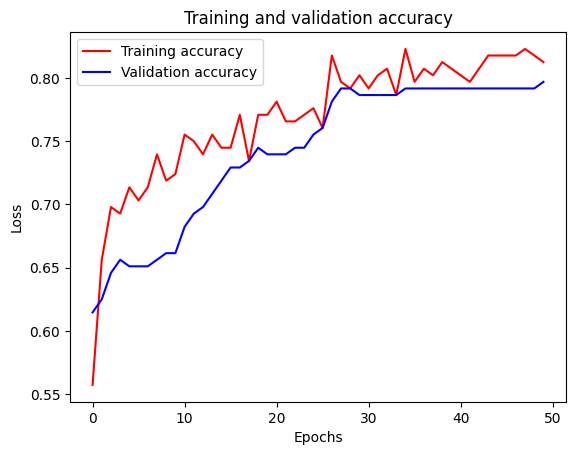

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict["accuracy"]
val_loss_values = history_dict["val_accuracy"]

plt.plot(loss_values, "b",color='red', label="Training accuracy")
plt.plot(val_loss_values, "b",color='blue', label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
import kerastuner as kt

def build_model(hp):
    units = hp.Int(name="units", min_value=16, max_value=64, step=16)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    l2_reg_rate = hp.Float('l2_reg_rate', min_value=1e-5, max_value=1e-2, step=1e-5)
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, step=1e-5)

    inputs = keras.Input(shape=(14,))

    features = inputs
    for i in range(hp.Int('num_layers', 2, 5)):
        features = layers.Dense(units, activation='relu', kernel_regularizer=l2(l2_reg_rate))(features)

        if hp.Boolean('batch_norm_after_layer_' + str(i)):
            features = layers.BatchNormalization()(features)

        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(1, activation="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [ ]:
tuner = kt.BayesianOptimization(
    build_model,
    objective="val_accuracy",
    max_trials=30,
    executions_per_trial=2,
    directory="test",
    project_name='binary_crossentropy_tuning',
    overwrite=True,
)

In [ ]:
tuner.search(train_data, train_label,
             epochs=30,
             validation_data=(val_data, val_label))

Trial 30 Complete [00h 00m 28s]
val_accuracy: 0.7239583432674408

Best val_accuracy So Far: 0.8125
Total elapsed time: 00h 12m 33s


In [ ]:
best_hps = tuner.get_best_hyperparameters()

In [ ]:
def get_best_epoch(hp):
    model = build_model(hp)
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", mode="min", patience=10)
    ]
    history = model.fit(
        train_data, train_label,
        validation_data=(val_data, val_label),
        epochs=100,
        batch_size=32,
        callbacks=callbacks)
    val_loss_per_epoch = history.history["val_loss"]
    best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
    print(f"Best epoch: {best_epoch}")
    return best_epoch

In [ ]:
def get_best_trained_model(hp):
    best_epoch = get_best_epoch(hp)
    return model

In [ ]:
best_models = []

for hp in best_hps:
    model = get_best_trained_model(hp)
    best_models.append(model)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.5708 - loss: 1.6282 - val_accuracy: 0.7135 - val_loss: 1.5418
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6952 - loss: 1.4689 - val_accuracy: 0.7812 - val_loss: 1.5088
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7757 - loss: 1.3947 - val_accuracy: 0.7656 - val_loss: 1.4844
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7903 - loss: 1.3429 - val_accuracy: 0.7969 - val_loss: 1.4557
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8127 - loss: 1.2866 - val_accuracy: 0.7812 - val_loss: 1.4320
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7568 - loss: 1.3142 - val_accuracy: 0.7865 - val_loss: 1.4103
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8173 - loss: 1.2627 - val_accuracy: 0.7812 - val_loss: 1.3915
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8368 - loss: 1.1939 - val_accuracy: 0.7812 - val_loss:

In [ ]:
model.evaluate(test_data, test_label)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8307 - loss: 0.4557


[0.45071911811828613, 0.8333333134651184]